# Implementing an Image-Similarity Cache on AlexNet

*Note to COS316 Graders: Our contribution to the codebase primarily starts at the point "Creating a Cache of Trained Images" in the outline.*

In this notebook we will be implementing a modified version of [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), a neural network model that uses convolutional neural network (CNN) layers and was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/). AlexNet is famous for winning the ImageNet challenge in 2012 by beating the second place competitor by over 10% accuracy and kickstarting the interest in deep learning for computer vision.

The image below shows the architecture of AlexNet.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/alexnet.png?raw=1)

Confusingly, there are two "paths" of processing through the network. This is due to the original AlexNet model being implemented on two GPUs in parallel. Almost all implementations of AlexNet are now on a single GPU and our implementation is too.

We are now moving on from the MNIST dataset and from now on we will be using the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. CIFAR10 consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/cifar10.png?raw=1)

We will also show how to initialize the weights of our neural network and how to find a suitable learning rate using a modified version of the [learning rate finder](https://arxiv.org/abs/1506.01186).

Like the previous notebooks we'll implement our model, measure its performance on the dataset, and then have a short look into seeing what the model has learned.

Most of this notebook will be similar to the previous ones thus we will skim over code that has been shown before. We can look at the previous notebook for a refresher if needed.

### Data Processing

As always, we'll import the modules we need. A new import is the `_LRScheduler` which we will use to implement our learning rate finder.

In [ ]:
!pip install pytorch-msssim
# If not installed

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

We set the random seed so all of our experiments can be reproduced.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We calculate the mean and standard deviation of our data so we can normalize it.

Our dataset is made up of color images but three color channels (red, green and blue), compared to MNIST's black and white images with a single color channel. To normalize our data we need to calculate the means and standard deviations for each of the color channels independently.

To do this we pass a tuple containing the axes we want to take the means and standard deviations over to the `mean` and `std` functions and we receive a list of means and standard deviations for each of the three color channels.

In [ ]:
ROOT = '.data'

train_data = datasets.CIFAR10(root=ROOT,
                              train=True,
                              download=True)

means = train_data.data.mean(axis=(0, 1, 2)) / 255
stds = train_data.data.std(axis=(0, 1, 2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Next up is defining the transforms for data augmentation.

The images in the CIFAR10 dataset are significantly more complex than the MNIST dataset. They are larger, have three times the amount of pixels and are more cluttered. This makes them harder to learn and consequently means we should use less augmentation.

A new transform we use is `RandomHorizontalFlip`. This, with a probability of `0.5` as specified, flips the image horizontally. So an image of a horse facing to the right will be flipped so it will face to the left. We couldn't do this in the MNIST dataset as we are not expecting our test set to contain any flipped digits, however natural images, such as those in the CIFAR10 dataset, can potentially be flipped as they still make visual sense.

As our `means` and `stds` are now already in lists we do not need to enclose them in lists as we did for the single channel images in the MNIST dataset.

In [ ]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

In [ ]:
train_data = datasets.CIFAR10(ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

**bold text**...create a validation set from our training set...

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

...and ensure our validation set uses
the test transforms.

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

We print out the number of examples in each set of data to ensure everything has gone OK so far.

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Now, we'll create a function to plot some images in our dataset to see what they actually look like.

Note that by default PyTorch handles images that are arranged `[channel, height, width]`, but `matplotlib` expects images to be `[height, width, channel]`, hence we need to `permute` our images before plotting them.

Ignore the `normalize` argument for now, we'll explain it shortly.

In [ ]:
def plot_images(images, labels, classes, normalize=False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min=image_min, max=image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

Then, we'll actually plot the images.

We get both the images and the labels from the training set and convert the labels, which are originally stored as integers, into their human readable class by using the data's `classes` dictionary.

When we plot them we see lots of warnings. This is because `matplotlib` is expecting the values of every pixel to be between $[0, 1]$, however our normalization will cause them to be outside this range. By default `matplotlib` will then clip these values into the $[0,1]$ range. This clipping causes all the images to look a bit weird - all the colors are oversaturated.

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes, normalize=True)

A solution to this is to *renormalize* the images so each pixel is between $[0,1]$. This is done by clipping the pixel values between the maximum and minimum within an image and then scaling each pixel between $[0,1]$ using these maximum and minimums.

As we can see the images below look a lot more like we were expecting, along with the rotations and cropping.

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

As before, we'll check what images look like with Sobel filters applied to them.

In [ ]:
def plot_filter(images, filter, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
    filter = filter.repeat(3, 3, 1, 1)

    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    images = images.permute(0, 2, 3, 1)
    filtered_images = filtered_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize=(25, 5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title('Filtered')
        ax.axis('off')

The filters are still 2-dimensional but they are expanded to a depth of three dimensions inside the `plot_filter` function.

Below is a filter which detects horizontal lines.

Here's a filter that detects vertical lines.

We'll also do the same for subsampling/pooling.

In [ ]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

### Defining the Model

Next up is defining the model.

The actual model itself is no more difficult to understand than the previous model, LeNet. It is made up of convolutional layers, pooling layers and ReLU activation functions. See the previous notebook for a refresher on these concepts.

There are only two new concepts introduced here, `nn.Sequential` and `nn.Dropout`.

We can think of `Sequential` as like our transforms introduced earlier for data augmentation. We provide `Sequential` with multiple layers and when the `Sequential` module is called it will apply each layer, in order, to the input. There is no difference between using a `Sequential` and having each module defined in the `__init__` and then called in `forward` - however it makes the code significantly shorter.

We have one `Sequential` model, `features`, for all the convolutional and pooling layers, then we flatten then data and pass it to the `classifier`, another `Sequential` model which is made up of linear layers and the second new concept, *dropout*.

Dropout is a form of [*regularization*](https://en.wikipedia.org/wiki/Regularization_(mathematics)). As our models get larger, to perform more accurately on richer datasets, they start having a significantly higher number of parameters. The problem with lots of parameters is that our models begin to *overfit*. That is, they do not learn general image features whilst learning to classify images but instead simply memorize images within the training set. This is bad as it will cause our model to achieve poor performance on the validation/testing set. To solve this overfitting problem, we use regularization. Dropout is just one method of regularization, other common ones are *L1 regularization*, *L2 regularization* and *weight decay*.

Dropout works by randomly setting a certain fraction, 0.5 here, of the neurons in a layer to zero. This effectively adds noise to the training of the neural network and causes neurons to learn with "less" data as they are only getting half of the information from a previous layer with dropout applied. It can also be thought of as causing your model to learn multiple smaller models with less parameters.

Dropout is only applied when the model is training. It needs to be "turned off" when validating, testing or using the model for inference.

As mentioned in the previous notebook, during the convolutional and pooling layers the activation function should be placed **after** the pooling layer to reduce computational cost.

In the linear layers, dropout should be applied **after** the activation function. Although when using ReLU activation functions the same result is achieved if dropout is before or after, see [here](https://sebastianraschka.com/faq/docs/dropout-activation.html).

One last thing to mention is that the very first convolutional layer has an `in_channel` of three. That is because we are handling color images that have three channels (red, green and blue) instead of the single channel grayscale images from the MNIST dataset. This doesn't change the way any of the convolutional filter works, it just means the first filter has a depth of three instead of a depth of one.

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        # Normal forward pass
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)

        return x, h

We'll create an instance of our model with the desired amount of classes.

In [ ]:
OUTPUT_DIM = 10

model = AlexNet(OUTPUT_DIM)

Then we'll see how many trainable parameters our model has.

Our LeNet architecture had ~44k, but here we have 23.2M parameters - and AlexNet is a relatively small model for computer vision.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,272,266 trainable parameters


### Training the Model

Next up, we'll initialize the parameters of our model.

PyTorch's default initialization is usually fine however by manually trying different initialization schemes we can usually squeeze out a slight performance improvement.

We initialize parameters in PyTorch by creating a function that takes in a PyTorch module, checking what type of module it is, and then using the `nn.init` methods to actually initialize the parameters.

For our convolutional layers, we'll initialize the weights from a Normal distribution with a standard deviation given by:

$$\frac{\text{gain}}{\sqrt{\text{fan mode}}}$$

The value of $\text{gain}$ depends on the non-linearity we will be using after the convolutional layer and we simply tell the initialization function that we are using ReLU which sets the gain to $\sqrt{2}$. The fan mode can be either `fan_in` or `fan_out`. `fan_in` is the number of connections coming into the layer and `fan_out` is the number of connections going out of the layer. For the first convolutional layer the input is from 3x3x3 filter, so the `fan_in` is 27 and the output is 64x3x3,  so the `fan_out` is 576. We leave it to the default `fan_in` mode. This initialization scheme is called *Kaiming Normal*, also known as *He Normal*. See the [paper](https://arxiv.org/abs/1502.01852) to learn more about how it was devised.

For the linear layers we initialize with a Normal distribution but this time the standard deviation is given by:

$$\text{gain} \times \sqrt{\frac{2}{\text{fan_in} + \text{fan_out}}}$$

Confusingly, instead of just telling the initialization function which non-linearity we want to use and have it calculate the gain for us, we have to tell it what gain we want to use. Luckily, `nn.init` has a `calculate_gain` function which does that for us, and we just tell it we are using ReLUs. This type of initialize scheme is called *Xavier Normal*, also known as *Glorot Normal*. See the [paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) for the theory behind it.

For both types of layer we initialize the bias terms to zeros.

Why do we even need to initialize our parameters this way? See [this](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79) article for a great explanation, but the gist of it is that just like how we normalized our input data to have a mean of 0 and a standard deviation of 1, we also want the outputs of each activation function (and therefore the inputs to the subsequent layer) to also have a mean of 0 and a standard deviation of 1. These initialization schemes, by taking account the number of connections in to and out of a layer as well as the non-linearity used, help achieve this normalization effect when initializing weights.

In [ ]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

We apply the initialization by using the model's `apply` method. This will call the given function on every module and sub-module within the model.

In [ ]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

To prepare to use the range finder we define an initial, very low starting learning rate and then create an instance of the optimizer we want to use with that learning rate.

We then define the loss function we want to use, the device we'll use and place our model and criterion on to our device.

In [ ]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=FOUND_LR)

The rest of the notebook is pretty similar to the previous notebooks from these tutorials.

We define a function to calculate accuracy...

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc, top_pred

...and a function to implement our training loop.

As we are using dropout we need to make sure to "turn it on" when training by using `model.train()`.

# Creating a Cache of trained images


In [ ]:
import torch
from collections import defaultdict

class MeanStdSimilarityCache():
    def __init__(self, k=10):
        self.cache = {}  # To store image data: (mean, std, label)
        self.valueToNum = defaultdict(int)  # Track count of each label
        self.valueToKey = {}  # Track keys for each label
        self.k = k

    def add(self, key, mean, std, label, logits):
      value = (mean, std, label, logits)

      if label in self.valueToNum and self.valueToNum[label] >= self.k:
          # gets all the keys from the self.valueToKey dict
          keysToChoose = self.valueToKey[label]

          # chooses a random key
          randKey = keysToChoose[random.randrange(len(keysToChoose))]

          # deletes that key,value pair from the cache
          del self.cache[randKey]
          del self.valueToKey[label]
          self.valueToNum[label] = self.valueToNum.get(label, 0) - 1

      self.cache[key] = value

      if label not in self.valueToKey:
          self.valueToKey[label] = []
      self.valueToKey[label].append(key)
      self.valueToNum[label] = self.valueToNum.get(label, 0) + 1

    def get(self, key):
        return self.cache[key]

    def get_keys(self):
        return self.cache.keys()

    def get_all_as_tensors(self):
        # Extract means, stds, and labels as separate lists
        means, stds, labels, logits = zip(*self.cache.values())

        # Convert lists to tensors
        means_tensor = torch.tensor(means)
        stds_tensor = torch.tensor(stds)
        # labels_tensor = torch.tensor(labels)
        # logits_tensor = torch.tensor(logits)
        logits_tensor = torch.stack(logits)


        return means_tensor, stds_tensor, logits_tensor

    # TODO make sure images are tensor
    def get_all_images_and_labels(self):
        # Extract images and labels as separate lists
        means, stds, labels, logits = zip(*self.cache.values())

        # Convert lists to tensors
        images_list = [torch.tensor(key_tuple) for key_tuple in self.cache.keys()]
        images_tensor = torch.stack(images_list)
        logits_tensor = torch.stack(logits)


        return images_tensor, logits_tensor

In [ ]:
def train(model, iterator, optimizer, criterion, device, epoch, numEpochs):

    cache = MeanStdSimilarityCache()

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        yCopy = y.numpy()
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc, top_pred = calculate_accuracy(y_pred, y)

        if epoch == numEpochs - 1:
          x_mean = x.mean(dim=[1, 2, 3]).to(device)  # Mean over channels, height and width
          x_std = x.std(dim=[1, 2, 3]).to(device)   # Std over channels, height and width

          # getting the actual labels of the batch
          curBatchLabels = np.array(classes)[yCopy]
          # getting the predicted labels of the batch
          curBatchPredLabels = np.array(classes)[top_pred.cpu().detach().numpy().reshape(-1)]

          for i in range(len(curBatchLabels)):
              if curBatchLabels[i] == curBatchPredLabels[i]:
                img_tuple = tuple(x[i].flatten().tolist())  # Key for cache
                label = curBatchLabels[i]  # Actual label
                logits = y_pred[i] # Logits for model prediction
                mean = x_mean[i]  # Mean of image
                std = x_std[i]  # Std of image
                cache.add(img_tuple, mean, std, label, logits)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), cache

We also define an evaluation loop, making sure to "turn off" dropout with `model.eval()`.

In [ ]:
# if evaluating MSS cache, run this evaluate method
def evaluate(model, iterator, criterion, device, threshold = 0.001, cache_for_evaluation=None):
    numHits = 0
    numTotal = 0
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
          x = x.to(device)
          y = y.to(device)

          if cache_for_evaluation:
            # Compute means for the batch
            x_mean = x.mean(dim=[1, 2, 3]).to(device)

            # Retrieve means and stds from cache as tensors
            cached_means, cached_stds, cached_logits = cache.get_all_as_tensors()
            cached_means = cached_means.to(device)
            cached_stds = cached_stds.to(device)

            # Find matches using tensor operations
            diff = (x_mean.unsqueeze(1) - cached_means).abs()
            within_std = diff < (threshold * cached_stds)
            cache_hits = within_std.any(dim=1)

            y_pred = torch.full((x.size(0), 10), -1.0, device=device)

            # For images found in cache
            numHits += sum(cache_hits)
            numTotal += x.shape[0]
            if cache_hits.any():
                indices = cache_hits.nonzero(as_tuple=True)[0]
                logits_indices = within_std[indices].max(dim=1).indices
                for i, idx in enumerate(indices):
                    y_pred[idx] = cached_logits[logits_indices[i]]

            # For images not in cache
            non_cached_indices = (y_pred == -1).nonzero(as_tuple=True)[0]
            if non_cached_indices.size(0) > 0:
                y_pred_non_cached, _ = model(x[non_cached_indices])
                y_pred[non_cached_indices] = y_pred_non_cached


          else:
            y_pred, _ = model(x)
            #print(y_pred.shape)
            #print((y_pred[0]).shape)

          loss = criterion(y_pred, y)
          acc, _ = calculate_accuracy(y_pred, y)
          epoch_loss += loss.item()
          epoch_acc += acc.item()
    if cache_for_evaluation is not None:
        print(f'Hit rate is {numHits/numTotal * 100} percent')
    return epoch_loss / len(iterator), epoch_acc / len(iterator), numHits/numTotal * 100 if cache_for_evaluation is not None else 0

In [ ]:
# If using SSIM cache, run this evaluate method
from torch import nn
from pytorch_msssim import SSIM
from tqdm.notebook import tqdm

def batch_ssim(x, cached_images, device):
    # Preallocate tensor for SSIM values
    ssim_values = torch.empty(x.size(0), cached_images.size(0), device=device, dtype=torch.float32)
    # Unnormalize images for SSIM, see here: https://github.com/VainF/pytorch-msssim#2-normalized-input
    x = (x + 1) / 2
    cached_images = (cached_images + 1) / 2

    # Compute SSIM in batches
    for i, image in enumerate(x):
        # Repeat the image to match the number of cached images
        repeated_image = image.repeat(cached_images.size(0), 1, 1, 1)

        # Compute SSIM for the batch
        # reuse the gaussian kernel due to channels, see here: https://github.com/VainF/pytorch-msssim
        ssim_module = SSIM(data_range=1, channel=3)
        ssim_values[i] = ssim_module(repeated_image, cached_images)

    return ssim_values

def evaluate(model, iterator, criterion, device, threshold = 0.002, cache_for_evaluation=None):
    epoch_loss = 0
    epoch_acc = 0
    numHits = 0
    numTotal = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)

            if cache_for_evaluation:
                # Retrieve cached images and their labels = logits
                cached_images, cached_logits = cache.get_all_images_and_labels()
                cached_images_reshaped = cached_images.view(-1, 3, 32, 32).to(device)

                # Compute SSIM for the entire batch
                ssim_scores = batch_ssim(x, cached_images_reshaped, device)

                # Find the indices of the maximum SSIM scores for each image
                max_ssim_indices = ssim_scores.argmax(dim=1)
                max_ssim_values = ssim_scores.max(dim=1).values

                # Apply SSIM threshold
                ssim_threshold_mask = max_ssim_values >= threshold # SSIM is highly sensitive, so threshold is low

                # Initialize predictions tensor with default values
                y_pred = torch.full((x.size(0),10), -1.0, device=device)  # Initialize with invalid class index


                # Use cached logits where SSIM is above threshold
                valid_indices = ssim_threshold_mask.nonzero(as_tuple=True)[0]
                if valid_indices.size(0) > 0:
                    y_pred[valid_indices] = cached_logits[max_ssim_indices[valid_indices]]
                numHits += valid_indices.size(0)
                numTotal += x.shape[0]

                # For images not in cache
                non_cached_indices = (~ssim_threshold_mask).nonzero(as_tuple=True)[0]
                if non_cached_indices.size(0) > 0:
                    y_pred_non_cached, _ = model(x[non_cached_indices])
                    y_pred[non_cached_indices] = y_pred_non_cached

            else:
                y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            acc, _ = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), numHits/numTotal * 100 if cache_for_evaluation is not None else 0


Next, we define a function to tell us how long an epoch takes.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, finally, we train our model.

We get a best validation loss of ~76% accuracy.

In [ ]:
# reset model as needed

OUTPUT_DIM = 10

model = AlexNet(OUTPUT_DIM)

model.apply(initialize_parameters)

START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

FOUND_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=FOUND_LR)

In [ ]:
EPOCHS = 25

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()


    train_loss, train_acc, cache = train(model, train_iterator, optimizer, criterion, device, epoch, EPOCHS)
    valid_loss, valid_acc, hitrate = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    #print(f'\t Cache: {cache.get_keys()}')
    print(f'\t Cache Length: {len(cache.get_keys())}')

We then load the parameters of our model that achieved the best validation loss and evaluate this model on the test set to achieve a ~75% accuracy.

In order to run K Experiments, one has to retrain the model on different values of k by editing the self.k parameter in the cache class and then run the following two code cells for MSS and SSIM respectively

In [ ]:
# if evaluating MSS cache, run this cell
model.load_state_dict(torch.load('tut3-model.pt'))

start_time = time.monotonic()
test_loss, test_acc, hitRate = evaluate(model, test_iterator, criterion, device, cache_for_evaluation=cache)
end_time = time.monotonic()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)


print(f'{epoch_mins} Minutes {epoch_secs} Seconds')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
print(f'HitRate: {hitRate}')

In [ ]:
# if evaluating SSIM cache, run this cell
model.load_state_dict(torch.load('tut3-model.pt'))

start_time = time.monotonic()
test_loss, test_acc, hits = evaluate(model, test_iterator, criterion, device, threshold=0.02, cache_for_evaluation=cache)
end_time = time.monotonic()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)


print(f'{epoch_mins} Minutes {epoch_secs} Seconds')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
print(f'hits: {hits:.3f}%')

The following two cell blocks are for running the Threshold Experiments on either MSS or SSIM

In [ ]:
# if testing MSS cache
threshold_vals = []
i = 0.0001
while i <= 0.01:
  threshold_vals.append(i)
  i += 0.0001


# times in seconds
threshold_vals = [0.001]
epoch_times = []
epoch_testLoss = []
epoch_testAcc = []
epoch_hitRate = []


for threshold in threshold_vals:
  model.load_state_dict(torch.load('tut3-model.pt'))


  start_time = time.monotonic()
  test_loss, test_acc, hitRate = evaluate(model, test_iterator, criterion, device, threshold = threshold,  cache_for_evaluation=cache)
  end_time = time.monotonic()


  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  epoch_times.append(epoch_mins * 60 + epoch_secs)
  epoch_testLoss.append(test_loss)
  epoch_testAcc.append(test_acc)
  epoch_hitRate.append(hitRate.item())

In [ ]:
# if testing SSIM, run this cell
threshold_vals = []

i = 0.0001
while i <= 0.02:
  threshold_vals.append(i)
  i += 0.0002
threshold_vals = [0.0001]
# times in seconds
epoch_times = []
epoch_testLoss = []
epoch_testAcc = []
epoch_hitRate = []


for threshold in threshold_vals:
  model.load_state_dict(torch.load('tut3-model.pt'))


  start_time = time.monotonic()
  test_loss, test_acc, hitRate = evaluate(model, test_iterator, criterion, device, threshold = threshold,  cache_for_evaluation=cache)
  end_time = time.monotonic()


  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  epoch_times.append(epoch_mins * 60 + epoch_secs)
  epoch_testLoss.append(test_loss)
  epoch_testAcc.append(test_acc)
  epoch_hitRate.append(hitRate.item())

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5))  # Optional: setting the figure size
plt.plot(threshold_vals, epoch_testAcc, marker='o', linestyle='-')
plt.title('Test Dataset Accuracies vs Threshold Values')
plt.xlabel('Threshold Values')
plt.ylabel('Accuracy (%)')
plt.axhline(y=0.757, color='red', linestyle='--', label='Baseline Accuracy at 0.757')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 5))  # Optional: setting the figure size
plt.plot(threshold_vals, epoch_testLoss, marker='o', linestyle='-')
plt.title('Test Dataset Loss vs Threshold Values')
plt.xlabel('Threshold Values')
plt.ylabel('Loss')
plt.axhline(y=0.700, color='red', linestyle='--', label='Baseline Test Loss at 0.700')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 5))  # Optional: setting the figure size
plt.scatter(threshold_vals, epoch_times, marker='o')  # Scatter plot
plt.title('Time to Run One Epoch over Test Dataset vs Threshold Values')
plt.xlabel('Threshold Values')
plt.ylabel('Time (sec)')
plt.grid(True)
plt.axhline(y=3, color='red', linestyle='--', label='Baseline Test Time at 3 seconds')
plt.legend()
plt.show()


plt.figure(figsize=(8, 5))  # Optional: setting the figure size
plt.plot(threshold_vals, epoch_hitRate, marker='o', linestyle='-')
plt.title('Hit Rate vs Threshold Values')
plt.xlabel('Threshold Values')
plt.ylabel('Percentage')
plt.grid(True)
plt.show()

Plotting Confusion Matrices

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator, device)

Then, for each prediction we get the predicted class.

In [ ]:
pred_labels = torch.argmax(probs, 1)

Next, we plot the confusion matrix. This time we have edited the function to allow us to pass a list of strings which are the labels classes.

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

### Plotting results for K-experiments

Note that we hard-coded the results of the K-value because we had to retrain the model and populate the cache for each experiment. These lists track our observed outputs from running the experiments.

**MSS** Cache Data

*   Threshold Constant within 0.001 cached standard deviation
*   K changed from 1 to 45

**SSIM** Cache Data

*   Threshold Constant set to 0.02
*   K changed from 1 to 45





In [ ]:
kVals = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45]
baselineTime = [3, 3, 4, 3, 4, 5, 7, 6, 5, 6]
baselineLoss = [0.707, 0.700, 0.708, 0.696, 0.7, 0.693, 0.724, 0.709, 0.740, 0.702]
baselineAcc = [75.91, 76.51, 75.86, 76.67, 75.7, 76.41, 75.2, 75.73, 75.19, 76.11]

MSS_cacheHitRate = [1.020, 5.470, 9.75, 15.360, 19.930, 24.130, 28.960, 32.780, 34.890, 37.530]
MSS_cacheTime = [5, 7, 5, 5, 9, 7, 7, 5, 5, 9]
MSS_cacheLoss = [0.752, 1.233, 1.373, 1.762, 2.389, 2.515, 2.937, 3.479, 3.044, 3.491]
MSS_cacheAcc = [75.26, 72.88, 69.48, 66.48, 62.52, 60.53, 57.36, 54.34, 53.71, 52.26]

SSIM_cacheHitRate = [21.880, 10.690, 8.170, 9.550, 5.890, 5.920, 5.520, 6.220, 4.980, 5.520]
SSIM_cacheTime = [6, 5, 6, 6, 7, 7, 5, 7, 8, 7]
SSIM_cacheLoss = [2.828, 1.890, 1.576, 1.422, 1.307, 1.315, 1.269, 1.334, 1.216, 1.264]
SSIM_cacheAcc = [61.83, 68.74, 70.24, 69.22, 72.25, 72.08, 72.49, 71.85, 72.86, 72.43]

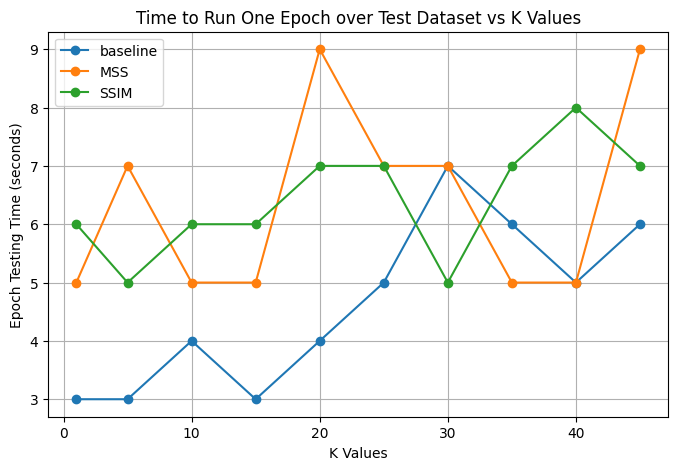

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))  # Optional: setting the figure size
plt.plot(kVals, baselineTime, marker='o', linestyle='-', label = 'baseline')
plt.plot(kVals, MSS_cacheTime, marker = 'o', linestyle = '-', label = 'MSS')
plt.plot(kVals, SSIM_cacheTime, marker = 'o', linestyle = '-', label = 'SSIM')
plt.title('Time to Run One Epoch over Test Dataset vs K Values')
plt.xlabel('K Values')
plt.ylabel('Epoch Testing Time (seconds)')
#plt.axhline(y=0.757, color='red', linestyle='--', label='Baseline Accuracy at 0.757')
plt.legend()
plt.grid(True)
plt.show()

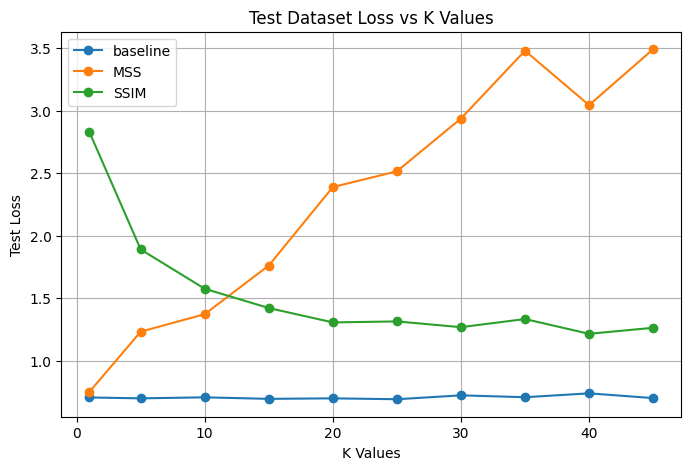

In [ ]:
plt.figure(figsize=(8, 5))  # Optional: setting the figure size
plt.plot(kVals, baselineLoss, marker='o', linestyle='-', label = 'baseline')
plt.plot(kVals, MSS_cacheLoss, marker = 'o', linestyle = '-', label = 'MSS')
plt.plot(kVals, SSIM_cacheLoss, marker = 'o', linestyle = '-', label = 'SSIM')
plt.title('Test Dataset Loss vs K Values')
plt.xlabel('K Values')
plt.ylabel('Test Loss')
#plt.axhline(y=0.757, color='red', linestyle='--', label='Baseline Accuracy at 0.757')
plt.legend()
plt.grid(True)
plt.show()

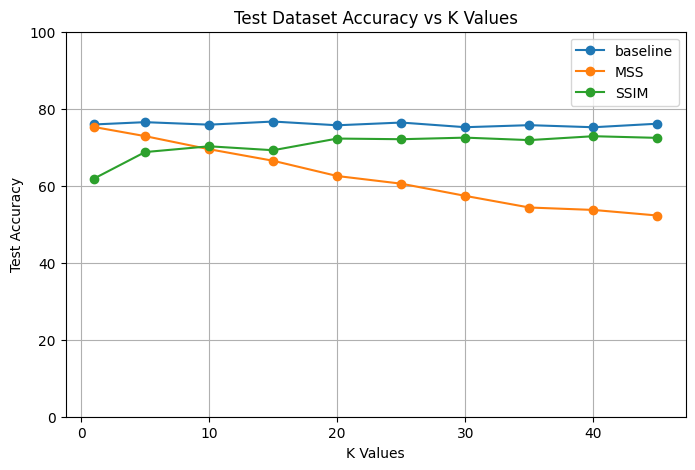

In [ ]:
plt.figure(figsize=(8, 5))  # Optional: setting the figure size
plt.plot(kVals, baselineAcc, marker='o', linestyle='-', label = 'baseline')
plt.plot(kVals, MSS_cacheAcc, marker = 'o', linestyle = '-', label = 'MSS')
plt.plot(kVals, SSIM_cacheAcc, marker = 'o', linestyle = '-', label = 'SSIM')
plt.title('Test Dataset Accuracy vs K Values')
plt.xlabel('K Values')
plt.ylabel('Test Accuracy')
plt.ylim(0, 100)  # Set y-axis limits
#plt.axhline(y=0.757, color='red', linestyle='--', label='Baseline Accuracy at 0.757')
plt.legend()
plt.grid(True)
plt.show()

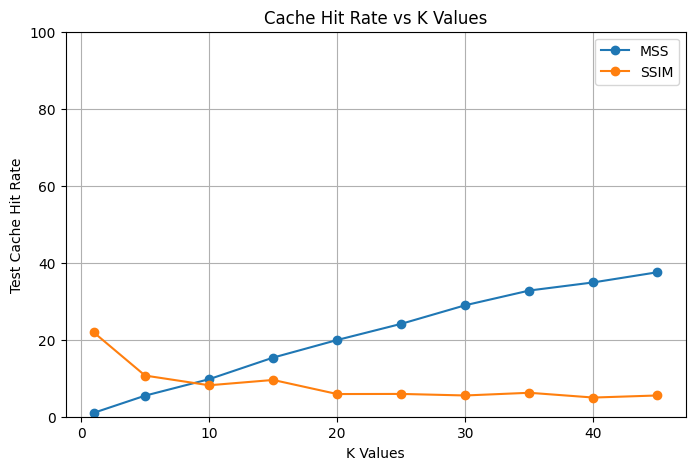

In [ ]:
plt.figure(figsize=(8, 5))  # Optional: setting the figure size
plt.plot(kVals, MSS_cacheHitRate, marker='o', linestyle='-', label = 'MSS')
plt.plot(kVals, SSIM_cacheHitRate, marker='o', linestyle='-', label = 'SSIM')
plt.title('Cache Hit Rate vs K Values')
plt.xlabel('K Values')
plt.ylabel('Test Cache Hit Rate')
plt.ylim(0, 100)  # Set y-axis limits
#plt.axhline(y=0.757, color='red', linestyle='--', label='Baseline Accuracy at 0.757')
plt.legend()
plt.grid(True)
plt.show()